In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from math import pi
from torch import nn
from torch.distributions.kl import kl_divergence
from random import randint
from random import shuffle

amplitude_range = (-1., 1.)
shift_range = (-.5, .5)
num_samples = 2000

#creates dataset
dataset = []
for i in range(num_samples):
    amplitude = np.random.uniform(amplitude_range[0], amplitude_range[1])
    shift = np.random.uniform(shift_range[0], shift_range[1])
    
    x = np.linspace(-pi, pi, 500)
    y = amplitude*np.sin(x+shift)
    dataset.append([x, y])
    
#visualize some samples
for i in range(64):
    x, y = dataset[i]
    plt.plot(x, y)
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
#models for the components of the neural process
x_dim = 1
y_dim = 1
r_dim = 2
z_dim = 2
r_encoder_hidden_dim = 10
n_encoder_hidden_dim = 10
decoder_hidden_dim = 10

class r_encoder(nn.Module):
    def __init__(self, x_dim, y_dim, r_dim, r_encoder_hidden_dim):
        super(r_encoder, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.r_dim = r_dim
        self.h_dim = r_encoder_hidden_dim
        
        self.fc1 = nn.Linear(self.x_dim + self.y_dim, self.h_dim)
        self.fc2 = nn.Linear(self.h_dim, self.h_dim)
        self.fc3 = nn.Linear(self.h_dim, self.r_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, y):
        input_pairs = torch.cat((x, y), dim=1)
        o1 = self.relu(self.fc1(input_pairs))
        o2 = self.relu(self.fc2(o1))
        r = self.fc3(o2)
        return r

class n_encoder(nn.Module):
    def __init__(self, z_dim, r_dim, r_encoder_hidden_dim):
        super(n_encoder, self).__init__()
        self.r_dim = r_dim
        self.h_dim = n_encoder_hidden_dim
        self.z_dim = z_dim
        
        self.fc1 = nn.Linear(self.r_dim, self.h_dim)
        self.fcmu = nn.Linear(self.h_dim, self.z_dim)
        self.fcstd = nn.Linear(self.h_dim, self.z_dim)
        self.relu = nn.ReLU()
        
    def forward(self, r):
        o1 = self.relu(self.fc1(r))
        mu = self.fcmu(o1)
        logvar = self.fcstd(o1)
        return mu, logvar
        
class decoder(nn.Module):
    def __init__(self, x_dim, z_dim, decoder_hidden_dim, y_dim):
        super(decoder, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.h_dim = decoder_hidden_dim
        self.y_dim = y_dim
        
        self.fc1 = nn.Linear(self.x_dim + self.z_dim, self.h_dim)
        self.fc2 = nn.Linear(self.h_dim, self.h_dim)
        self.fc3 = nn.Linear(self.h_dim, self.h_dim)
        self.fcmu = nn.Linear(self.h_dim, self.y_dim)
        self.fcstd = nn.Linear(self.h_dim, self.y_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, z):
        batch_size, num_points, _ = x.size()
        z = z.unsqueeze(1).repeat(1, num_points, 1)
        x_flat = x.view(batch_size*num_points, self.x_dim)
        z_flat = z.view(batch_size*num_points, self.z_dim)
        
        input_pairs = torch.cat((x_flat, z_flat), dim=1)
        o1 = self.relu(self.fc1(input_pairs))
        o2 = self.relu(self.fc2(o1))
        o3 = self.relu(self.fc3(o2))
        mu = self.fcmu(o3)
        logvar = self.fcstd(o3)
        return mu, logvar

In [4]:
import torch
from torch import nn
from torch.distributions import Normal
from python_utils import img_mask_to_np_input


class NeuralProcess(nn.Module):
    """
    Implements Neural Process for functions of arbitrary dimensions.
    Parameters
    ----------
    x_dim : int
        Dimension of x values.
    y_dim : int
        Dimension of y values.
    r_dim : int
        Dimension of output representation r.
    z_dim : int
        Dimension of latent variable z.
    h_dim : int
        Dimension of hidden layer in encoder and decoder.
    """
    def __init__(self, x_dim, y_dim, r_dim, z_dim, h_dim):
        super(NeuralProcess, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim

        # Initialize networks
        self.xy_to_r = r_encoder(x_dim, y_dim, h_dim, r_dim)
        self.r_to_mu_sigma = n_encoder(r_dim, z_dim)
        self.xz_to_y = decoder(x_dim, z_dim, h_dim, y_dim)

    def aggregate(self, r_i):
        """
        Aggregates representations for every (x_i, y_i) pair into a single
        representation.
        Parameters
        ----------
        r_i : torch.Tensor
            Shape (batch_size, num_points, r_dim)
        """
        return torch.mean(r_i, dim=1)

    def xy_to_mu_sigma(self, x, y):
        """
        Maps (x, y) pairs into the mu and sigma parameters defining the normal
        distribution of the latent variables z.
        Parameters
        ----------
        x : torch.Tensor
            Shape (batch_size, num_points, x_dim)
        y : torch.Tensor
            Shape (batch_size, num_points, y_dim)
        """
        batch_size, num_points, _ = x.size()
        # Flatten tensors, as encoder expects one dimensional inputs
        x_flat = x.view(batch_size * num_points, self.x_dim)
        y_flat = y.contiguous().view(batch_size * num_points, self.y_dim)
        # Encode each point into a representation r_i
        r_i_flat = self.xy_to_r(x_flat, y_flat)
        # Reshape tensors into batches
        r_i = r_i_flat.view(batch_size, num_points, self.r_dim)
        # Aggregate representations r_i into a single representation r
        r = self.aggregate(r_i)
        # Return parameters of distribution
        return self.r_to_mu_sigma(r)

    def forward(self, x_context, y_context, x_target, y_target=None):
        """
        Given context pairs (x_context, y_context) and target points x_target,
        returns a distribution over target points y_target.
        Parameters
        ----------
        x_context : torch.Tensor
            Shape (batch_size, num_context, x_dim). Note that x_context is a
            subset of x_target.
        y_context : torch.Tensor
            Shape (batch_size, num_context, y_dim)
        x_target : torch.Tensor
            Shape (batch_size, num_target, x_dim)
        y_target : torch.Tensor or None
            Shape (batch_size, num_target, y_dim). Only used during training.
        Note
        ----
        We follow the convention given in "Empirical Evaluation of Neural
        Process Objectives" where context is a subset of target points. This was
        shown to work best empirically.
        """
        # Infer quantities from tensor dimensions
        batch_size, num_context, x_dim = x_context.size()
        _, num_target, _ = x_target.size()
        _, _, y_dim = y_context.size()

        if self.training:
            # Encode target and context (context needs to be encoded to
            # calculate kl term)
            mu_target, sigma_target = self.xy_to_mu_sigma(x_target, y_target)
            mu_context, sigma_context = self.xy_to_mu_sigma(x_context, y_context)
            # Sample from encoded distribution using reparameterization trick
            q_target = Normal(mu_target, sigma_target)
            q_context = Normal(mu_context, sigma_context)
            z_sample = q_target.rsample()
            # Get parameters of output distribution
            y_pred_mu, y_pred_sigma = self.xz_to_y(x_target, z_sample)
            p_y_pred = Normal(y_pred_mu, y_pred_sigma)

            return p_y_pred, q_target, q_context
        else:
            # At testing time, encode only context
            mu_context, sigma_context = self.xy_to_mu_sigma(x_context, y_context)
            # Sample from distribution based on context
            q_context = Normal(mu_context, sigma_context)
            z_sample = q_context.rsample()
            # Predict target points based on context
            y_pred_mu, y_pred_sigma = self.xz_to_y(x_target, z_sample)
            p_y_pred = Normal(y_pred_mu, y_pred_sigma)

            return p_y_pred


class NeuralProcessImg(nn.Module):
    """
    Wraps regular Neural Process for image processing.
    Parameters
    ----------
    img_size : tuple of ints
        E.g. (1, 28, 28) or (3, 32, 32)
    r_dim : int
        Dimension of output representation r.
    z_dim : int
        Dimension of latent variable z.
    h_dim : int
        Dimension of hidden layer in encoder and decoder.
    """
    def __init__(self, img_size, r_dim, z_dim, h_dim):
        super(NeuralProcessImg, self).__init__()
        self.img_size = img_size
        self.num_channels, self.height, self.width = img_size
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim

        self.neural_process = NeuralProcess(x_dim=2, y_dim=self.num_channels,
                                            r_dim=r_dim, z_dim=z_dim,
                                            h_dim=h_dim)

    def forward(self, img, context_mask, target_mask):
        """
        Given an image and masks of context and target points, returns a
        distribution over pixel intensities at the target points.
        Parameters
        ----------
        img : torch.Tensor
            Shape (batch_size, channels, height, width)
        context_mask : torch.ByteTensor
            Shape (batch_size, height, width). Binary mask indicating
            the pixels to be used as context.
        target_mask : torch.ByteTensor
            Shape (batch_size, height, width). Binary mask indicating
            the pixels to be used as target.
        """
        x_context, y_context = img_mask_to_np_input(img, context_mask)
        x_target, y_target = img_mask_to_np_input(img, target_mask)
        return self.neural_process(x_context, y_context, x_target, y_target)

ImportError: cannot import name 'img_mask_to_np_input'

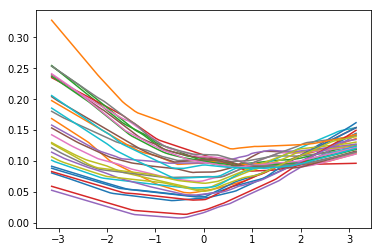

In [137]:
model = neural_process(1, 1, 2, 2, 10)

#samples from prior before training
x_target = torch.tensor(np.linspace(-pi, pi, 100)).float()
x_target = x_target.unsqueeze(1).unsqueeze(0)
for i in range(30):
    z_sample = torch.randn((1, z_dim)).float()
    mu, _ = model.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy())

In [126]:
import torch
from random import randint
from neural_process import NeuralProcessImg
from torch import nn
from torch.distributions.kl import kl_divergence
from utils import (context_target_split, batch_context_target_mask,
                   img_mask_to_np_input)


class NeuralProcessTrainer():
    """
    Class to handle training of Neural Processes for functions and images.
    Parameters
    ----------
    device : torch.device
    neural_process : neural_process.NeuralProcess or NeuralProcessImg instance
    optimizer : one of torch.optim optimizers
    num_context_range : tuple of ints
        Number of context points will be sampled uniformly in the range given
        by num_context_range.
    num_extra_target_range : tuple of ints
        Number of extra target points (as we always include context points in
        target points, i.e. context points are a subset of target points) will
        be sampled uniformly in the range given by num_extra_target_range.
    print_freq : int
        Frequency with which to print loss information during training.
    """
    def __init__(self, device, neural_process, optimizer, num_context_range,
                 num_extra_target_range, print_freq=100):
        self.device = device
        self.neural_process = neural_process
        self.optimizer = optimizer
        self.num_context_range = num_context_range
        self.num_extra_target_range = num_extra_target_range
        self.print_freq = print_freq

        # Check if neural process is for images
        self.is_img = isinstance(self.neural_process, NeuralProcessImg)
        self.steps = 0
        self.epoch_loss_history = []

    def train(self, data_loader, epochs):
        """
        Trains Neural Process.
        Parameters
        ----------
        dataloader : torch.utils.DataLoader instance
        epochs : int
            Number of epochs to train for.
        """
        for epoch in range(epochs):
            epoch_loss = 0.
            for i, data in enumerate(data_loader):
                self.optimizer.zero_grad()

                # Sample number of context and target points
                num_context = randint(*self.num_context_range)
                num_extra_target = randint(*self.num_extra_target_range)

                # Create context and target points and apply neural process
                if self.is_img:
                    img, _ = data  # data is a tuple (img, label)
                    batch_size = img.size(0)
                    context_mask, target_mask = \
                        batch_context_target_mask(self.neural_process.img_size,
                                                  num_context, num_extra_target,
                                                  batch_size)

                    img = img.to(self.device)
                    context_mask = context_mask.to(self.device)
                    target_mask = target_mask.to(self.device)

                    p_y_pred, q_target, q_context = \
                        self.neural_process(img, context_mask, target_mask)

                    # Calculate y_target as this will be required for loss
                    _, y_target = img_mask_to_np_input(img, target_mask)
                else:
                    x, y = data
                    x_context, y_context, x_target, y_target = \
                        context_target_split(x, y, num_context, num_extra_target)
                    p_y_pred, q_target, q_context = \
                        self.neural_process(x_context, y_context, x_target, y_target)

                loss = self._loss(p_y_pred, y_target, q_target, q_context)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                self.steps += 1

                if self.steps % self.print_freq == 0:
                    print("iteration {}, loss {:.3f}".format(self.steps, loss.item()))

            print("Epoch: {}, Avg_loss: {}".format(epoch, epoch_loss / len(data_loader)))
            self.epoch_loss_history.append(epoch_loss / len(data_loader))

    def _loss(self, p_y_pred, y_target, q_target, q_context):
        """
        Computes Neural Process loss.
        Parameters
        ----------
        p_y_pred : one of torch.distributions.Distribution
            Distribution over y output by Neural Process.
        y_target : torch.Tensor
            Shape (batch_size, num_target, y_dim)
        q_target : one of torch.distributions.Distribution
            Latent distribution for target points.
        q_context : one of torch.distributions.Distribution
            Latent distribution for context points.
        """
        # Log likelihood has shape (batch_size, num_target, y_dim). Take mean
        # over batch and sum over number of targets and dimensions of y
        log_likelihood = p_y_pred.log_prob(y_target).mean(dim=0).sum()
        # KL has shape (batch_size, r_dim). Take mean over batch and sum over
        # r_dim (since r_dim is dimension of normal distribution)
        kl = kl_divergence(q_target, q_context).mean(dim=0).sum()
        return -log_likelihood + kl

In [ ]:
model.train()
train(dataset, 3)

EPOCH: 0 LOSS: 630953.6877093315


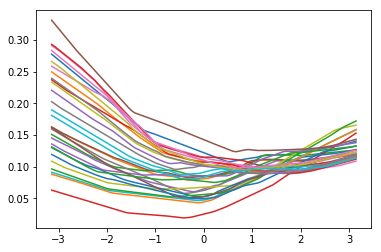

In [139]:
x_target = torch.tensor(np.linspace(-pi, pi, 100)).float()
x_target = x_target.unsqueeze(1).unsqueeze(0)
for i in range(30):
    z_sample = torch.randn((1, z_dim)).float()
    mu, _ = model.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy())

C:\Users\Stefan Clarke\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


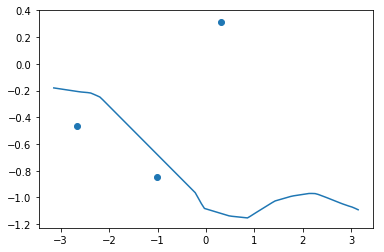

In [133]:
#a sample from a posterior
model.eval()
x_context = torch.tensor(np.random.uniform(-pi, pi, size=3)).reshape(1,3,1).float()
y_context = torch.tensor(np.sin(x_context)).reshape(1,3,1).type('torch.FloatTensor')
x_target = np.linspace(-pi, pi, 100).reshape(1, 100, 1)
x_target = torch.tensor(x_target).type('torch.FloatTensor')

y_pred = model(x_context, y_context, x_target)
mu = y_pred.loc.detach()
plt.plot(x_target.numpy()[0], mu.numpy())
plt.scatter(x_context.numpy()[0], y_context.numpy()[0])